In [1]:
import numpy as np
from acquire import get_zillow_data
from wrangle_zillow import wrangle_zillow, train_validate_test, Min_Max_Scaler, outlier_calculation
import matplotlib.pyplot as plt
import seaborn as sns

### Acquire and examine the data

Acquire the data from the zillow database ('Single Family Residential' properties from 2017)



In [2]:
df = get_zillow_data()

In [3]:
df

,propertylandusetypeid,transactiondate,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount
0,261.0,2017-07-21,1316.0,3.0,2.0,205123.0,2627.48
1,261.0,2017-06-23,1458.0,3.0,2.0,136104.0,2319.90
2,261.0,2017-06-30,1421.0,2.0,1.0,35606.0,543.69
3,261.0,2017-06-01,2541.0,4.0,3.0,880456.0,9819.72
4,261.0,2017-08-23,1491.0,3.0,2.0,107110.0,1399.27
...,...,...,...,...,...,...,...
28414,261.0,2017-08-31,1187.0,4.0,1.5,465999.0,5552.68
28415,261.0,2017-08-31,3015.0,5.0,3.0,852813.0,11662.88
28416,261.0,2017-08-31,2992.0,5.0,3.0,1120000.0,13663.03
28417,261.0,2017-08-31,1574.0,3.0,3.0,563463.0,6903.66


In [4]:
df.isnull().sum()

propertylandusetypeid            0
transactiondate                  0
calculatedfinishedsquarefeet    73
bedroomcnt                       0
bathroomcnt                      0
taxvaluedollarcnt                1
taxamount                        1
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28419 entries, 0 to 28418
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         28419 non-null  float64
 1   transactiondate               28419 non-null  object 
 2   calculatedfinishedsquarefeet  28346 non-null  float64
 3   bedroomcnt                    28419 non-null  float64
 4   bathroomcnt                   28419 non-null  float64
 5   taxvaluedollarcnt             28418 non-null  float64
 6   taxamount                     28418 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.5+ MB


In [6]:
df.shape

(28419, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28419 entries, 0 to 28418
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         28419 non-null  float64
 1   transactiondate               28419 non-null  object 
 2   calculatedfinishedsquarefeet  28346 non-null  float64
 3   bedroomcnt                    28419 non-null  float64
 4   bathroomcnt                   28419 non-null  float64
 5   taxvaluedollarcnt             28418 non-null  float64
 6   taxamount                     28418 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.5+ MB


In [8]:
# Rename the columns into something more readable
df = df.rename(columns={'propertylandusetypeid': 'land_use_typeid', 'bathroomcnt': 'num_bathrooms', 'bedroomcnt': 'num_bedrooms',
                       'calculatedfinishedsquarefeet': 'square_feet', 'taxvaluedollarcnt': 'appraised_value', 'taxamount': 'taxes'})

In [9]:
df.square_feet.describe()

count    28346.000000
mean      1931.750194
std       1013.652864
min        240.000000
25%       1276.000000
50%       1669.000000
75%       2319.000000
max      35640.000000
Name: square_feet, dtype: float64

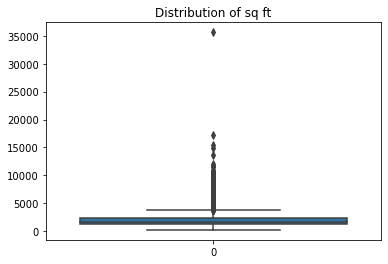

In [10]:
sns.boxplot(data=df.square_feet)
plt.title('Distribution of sq ft')
plt.show()

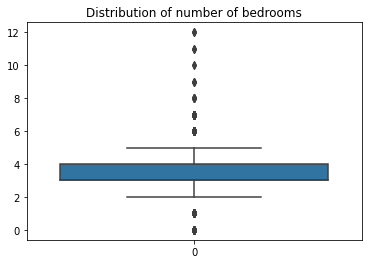

In [11]:
sns.boxplot(data=df.num_bedrooms)
plt.title('Distribution of number of bedrooms')
plt.show()

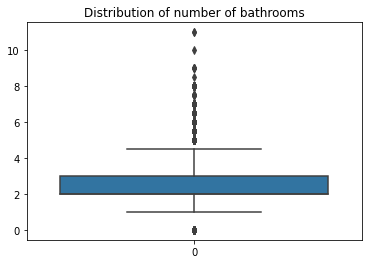

In [12]:
sns.boxplot(data=df.num_bathrooms)
plt.title('Distribution of number of bathrooms')
plt.show()

In [ ]:
df = df[(df.square_feet > lower) & (df.square_feet < upper)]

In [13]:
#Function to see outliers
def outlier_calculation(df, variable):
    '''
    calcualtes the lower and upper bound to locate outliers in variables
    '''
    quartile1, quartile3 = np.percentile(df[variable], [25,75])
    IQR_value = quartile3 - quartile1
    lower = quartile1 - (1.5 * IQR_value)
    upper = quartile3 + (1.5 * IQR_value)
    '''
    returns the lowerbound and upperbound values
    '''
    print(f'For {variable} the lower bound is {lower} and  upper bound is {upper}')
    df = df[(df[variable] > lower) & (df[variable] < upper)]
    return df

In [14]:
df = outlier_calculation(df, 'num_bedrooms')

For num_bedrooms the lower bound is 1.5 and  upper bound is 5.5


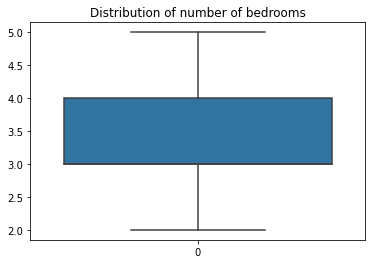

In [15]:
sns.boxplot(data=df.num_bedrooms)
plt.title('Distribution of number of bedrooms')
plt.show()

In [16]:
df = outlier_calculation(df, 'num_bathrooms')

For num_bathrooms the lower bound is 0.5 and  upper bound is 4.5


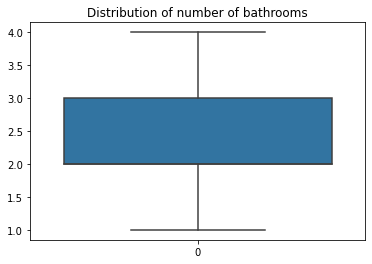

In [17]:
sns.boxplot(data=df.num_bathrooms)
plt.title('Distribution of number of bathrooms')
plt.show()

In [18]:
df = outlier_calculation(df, 'square_feet')

For square_feet the lower bound is -115.5 and  upper bound is 3576.5


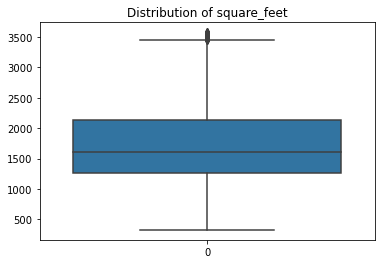

In [19]:
sns.boxplot(data=df.square_feet)
plt.title('Distribution of square_feet')
plt.show()

In [ ]:
df.info()

In [ ]:
# Plot with outliers removed
sns.boxplot(data=df.square_feet)
plt.title('Distribution of sq ft')
plt.show()

### Prep the data

In [ ]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [ ]:
# drop null values
df.dropna(axis=0, inplace=True)

In [ ]:
df.shape

In [ ]:
df

In [ ]:
#Make sure the nulls have been removed.
df.isna().sum()

In [ ]:
df

In [ ]:
df.transactiondate.value_counts(dropna=False, ascending=True)

In [ ]:
df.info()

In [ ]:
df1 = df.drop(columns=['transactiondate', 'land_use_typeid', 'taxes'])

In [ ]:
df1


In [ ]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df1, 'appraised_value')

In [ ]:
train.shape, validate.shape, test.shape

In [ ]:
train.head()

In [ ]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [ ]:
X_train_scaled

In [ ]:
sns.heatmap(train.corr(), cmap='coolwarm', center=0, annot=True, fmt='.0%')

plt.title('Correlation Heatmap of Variables')
plt.show()